# Causal Analysis of *How is the implementation of existing strategies affecting the rates of COVID-19 infection?*

*(Better displayed in [nbviewer](https://nbviewer.jupyter.org/) as red warnings in font tag may not be displayed on github)*

We believe that a question such as *How is the implementation of existing strategies affecting the rates of COVID-19 infection?* requires a proper causal analysis of the data.

Such question requires considering what the *causal effect* of certain strategies may be, and an evaluation of *counterfactual effects*.

To answer this question we rely on the formalism of [*causal models*](http://bayes.cs.ucla.edu/BOOK-2K/) and the [*dowhy*](https://github.com/microsoft/dowhy) library.


### Disclaimer
In this notebook we setup a <font color='red'>**preliminary template**</font> for a causal analysis of this question. In particular, we analyze data and we discusse its relevance.

<font color='red'>**This is a work in progress.**</font> Publishing this notebook has the sole aim to share an initial analysis and draws suggestions and critiques for improvement.

In no way, at the moment, these results should be taken to be significant. The data considered are limited, the model simplistic and debatable. <font color='red'>**NO conclusions on real world policies should be drawn from this notebook**</font>. 

Limitations will be highlighted in the notebook in RED (coloured fonts may not be displayed on github).

# Collecting treatment data for causal analysis

The aim of this notebook is to consider which sort of data we may need and we may collect for a proper causal model, focusing in particular on (i) treatment/exposure data.

In our model we may consider as *individuals* or *units* countries. This presents some relevant problems. Problems concerning the quality and quantity of the data are:
- <font color='red'>We can collect as many individual as countries (around 200). Is this enough for a reliable analysis?</font>
- <font color='red'>Data for different countries are reported by different sources. Is the quality of this data sufficiently homogeneous?</font>

This may be given we can not otherwise address.

Problems concerning the causal analysis are related to necessary assumptions for analysis:
- <font color='red'>With respect to SUTVA (stable unit treatment value assumption), can we assume that the outcome of one individual does not affect other individuals, that is, the outcome of a country is not affected by another?</font>
- <font color='red'>With respect to SUTVA again, can we assume that the treatment is the same for every individual, that is for every country?</font>

These two questions are particularly hard to answer, and requires **strong** assumptions. For instance, we may assume that the outcome of a quarantined country once affected by the pandemic is independent from the outcome of other countries. Similarly, we may assume that, although policies are inevitably implemented in different ways in different countries, they may be taken to be roughly the same.

The following analysis will be based on these assumptions.

## 1. Treatment data

In our model we want to evaluate the efficacy of policies enacted to contain the spread of covid-19. Naturally, we want to consider what measures are available.

### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

### Retrieving data

We collect information from the *HDE* dataset. This dataset reports measures adopted by each country together with the date the measure was adopted. We load the dataset, convert dates in a proper format, and check the cardinality of important fields.

In [2]:
HDE_df = pd.read_csv('HDE_update/acaps-covid-19-government-measures-dataset.csv')
HDE_df['date_implemented'] = pd.to_datetime(HDE_df['date_implemented'],format="%Y-%m-%d",errors='coerce')

measures = list(HDE_df['measure'].unique())
countries = list(HDE_df['iso'].unique()) 
days = (HDE_df['date_implemented'].max() - HDE_df['date_implemented'].min()).days

print('Number of measures: {0}'.format(len(measures)))
print('Number of countries: {0}'.format(len(countries)))
print('Number of days: {0}'.format(days))

Number of measures: 39
Number of countries: 193
Number of days: 121


The countries (193) could ideally be taken as our *individuals* or *units*. As expected, the number of samples is limited.

The dataset spans a wide range of days (121). This is inevitabile as these *measures/policies/treatments* are intended to work on timescale of multiple days or weeks. This unfortunately seems to preclude the preclude to perform a *discontinuity analysis* as the effect are expected to show up way after the discontinuity. Likely it will require the use of a *time-varying model*.

The number of measures is relatively high as well (39). This complicates the investigation as different countries enact several different policies at the same time, and it may be very hard to disentangle which policy may be responsible for which effect.

### Considering treatments

The large number of treatments raises a hard challenge: in a time-varying model we want to contrast two policies between two groups of individuals *ceteribus paribus* (keeping all other things similar or adjusted). Now, we can not *ignore* any measure, as any measure may be responsible for the effects that we observe.

This leads to an exponential number of possible treatments. A single treatment is given by a decision about each individual measure (39) on the range of days considered. Given we consider binary treatments, just on a single day we may have up to $2^{39}$ different treatments.

We collect the treatment followed by each individual country in matrix, where rows are measures and columns days.

In [3]:
countries_masks = {}
startingdate = HDE_df['date_implemented'].min()
endingdate = HDE_df['date_implemented'].max()

unknowns = 0
for c in countries:
    current_mask = np.zeros((len(measures),(endingdate-startingdate).days))
    
    for im,m in enumerate(measures):
        ds = HDE_df.loc[(HDE_df['iso']==c) & (HDE_df['measure']==m), 'date_implemented' ]
        if(ds.empty):
            print('In country {0} measure {1} was NEVER implemented'.format(c,m))
        else:
            ds = ds[pd.notna(ds)]
            if(ds.empty):
                unknowns += 1
                current_mask[im,:] = np.nan
                print('In country {0} measure {1} was implemented on UNKNOWN DATE'.format(c,m))
            else:
                d = ds.iloc[0]
                indexdate = (d - startingdate).days
                current_mask[im,indexdate:] = 1
                print('In country {0} measure {1} was implemented on {2}'.format(c,m,d))        
    countries_masks[c] = current_mask
        
print('Total NaT datetimes: {0}'.format(unknowns))   

In country AFG measure Health screenings in airports and border crossings was implemented on 2020-02-12 00:00:00
In country AFG measure Introduction of isolation and quarantine policies was implemented on 2020-02-12 00:00:00
In country AFG measure Awareness campaigns was implemented on 2020-02-12 00:00:00
In country AFG measure Emergency administrative structures activated or established was implemented on 2020-02-12 00:00:00
In country AFG measure Limit public gatherings was implemented on 2020-03-12 00:00:00
In country AFG measure Border closure was implemented on 2020-02-24 00:00:00
In country AFG measure Schools closure was implemented on 2020-03-01 00:00:00
In country AFG measure Strengthening the public health system was implemented on 2020-03-01 00:00:00
In country AFG measure Limit product imports/exports was implemented on 2020-03-01 00:00:00
In country AFG measure Border checks was implemented on 2020-02-01 00:00:00
In country AFG measure International flights suspension was 

In country ARG measure Health screenings in airports and border crossings was NEVER implemented
In country ARG measure Introduction of isolation and quarantine policies was implemented on 2020-03-12 00:00:00
In country ARG measure Awareness campaigns was implemented on 2020-02-17 00:00:00
In country ARG measure Emergency administrative structures activated or established was NEVER implemented
In country ARG measure Limit public gatherings was implemented on 2020-03-12 00:00:00
In country ARG measure Border closure was implemented on 2020-03-26 00:00:00
In country ARG measure Schools closure was implemented on 2020-03-16 00:00:00
In country ARG measure Strengthening the public health system was implemented on 2020-03-18 00:00:00
In country ARG measure Limit product imports/exports was NEVER implemented
In country ARG measure Border checks was NEVER implemented
In country ARG measure International flights suspension was implemented on 2020-03-12 00:00:00
In country ARG measure Surveillan

In country AUT measure Domestic travel restrictions was implemented on 2020-03-22 00:00:00
In country AUT measure State of emergency declared was NEVER implemented
In country AUT measure General recommendations was NEVER implemented
In country AUT measure Partial lockdown was implemented on 2020-03-16 00:00:00
In country AUT measure Checkpoints within the country was NEVER implemented
In country AUT measure Economic measures was implemented on 2020-03-14 00:00:00
In country AUT measure Curfews was implemented on UNKNOWN DATE
In country AUT measure Changes in prison-related policies was NEVER implemented
In country AUT measure Public services closure was implemented on 2020-03-16 00:00:00
In country AUT measure Military deployment was implemented on UNKNOWN DATE
In country AUT measure Full lockdown was NEVER implemented
In country AUT measure Visa restrictions was implemented on 2020-03-16 00:00:00
In country AUT measure Lockdown of refugee/idp camps or other minorities was NEVER implem

In country BGD measure strengthening the public health system was NEVER implemented
In country BGD measure Humanitarian exemptions was NEVER implemented
In country BGD measure Complete border closure was NEVER implemented
In country BGD measure curfews was NEVER implemented
In country BGD measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country BRB measure Health screenings in airports and border crossings was implemented on 2020-03-01 00:00:00
In country BRB measure Introduction of isolation and quarantine policies was implemented on 2020-03-08 00:00:00
In country BRB measure Awareness campaigns was implemented on 2020-03-11 00:00:00
In country BRB measure Emergency administrative structures activated or established was implemented on 2020-03-21 00:00:00
In country BRB measure Limit public gatherings was implemented on 2020-03-16 00:00:00
In country BRB measure Border closure was implemented on 2020-03-20 00:00:00
In country BRB measure Schools closure

In country BLZ measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country BEN measure Health screenings in airports and border crossings was implemented on 2020-03-03 00:00:00
In country BEN measure Introduction of isolation and quarantine policies was implemented on 2020-03-03 00:00:00
In country BEN measure Awareness campaigns was NEVER implemented
In country BEN measure Emergency administrative structures activated or established was NEVER implemented
In country BEN measure Limit public gatherings was implemented on 2020-03-19 00:00:00
In country BEN measure Border closure was implemented on 2020-03-19 00:00:00
In country BEN measure Schools closure was implemented on 2020-03-23 00:00:00
In country BEN measure Strengthening the public health system was NEVER implemented
In country BEN measure Limit product imports/exports was NEVER implemented
In country BEN measure Border checks was NEVER implemented
In country BEN measure International flights suspen

In country BIH measure curfews was NEVER implemented
In country BIH measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country BWA measure Health screenings in airports and border crossings was NEVER implemented
In country BWA measure Introduction of isolation and quarantine policies was implemented on 2020-03-24 00:00:00
In country BWA measure Awareness campaigns was NEVER implemented
In country BWA measure Emergency administrative structures activated or established was NEVER implemented
In country BWA measure Limit public gatherings was implemented on 2020-03-16 00:00:00
In country BWA measure Border closure was implemented on 2020-03-24 00:00:00
In country BWA measure Schools closure was NEVER implemented
In country BWA measure Strengthening the public health system was NEVER implemented
In country BWA measure Limit product imports/exports was NEVER implemented
In country BWA measure Border checks was NEVER implemented
In country BWA measure Internati

In country BGR measure curfews was NEVER implemented
In country BGR measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country BFA measure Health screenings in airports and border crossings was implemented on 2020-03-12 00:00:00
In country BFA measure Introduction of isolation and quarantine policies was implemented on 2020-03-27 00:00:00
In country BFA measure Awareness campaigns was implemented on 2020-02-13 00:00:00
In country BFA measure Emergency administrative structures activated or established was NEVER implemented
In country BFA measure Limit public gatherings was implemented on 2020-03-12 00:00:00
In country BFA measure Border closure was implemented on 2020-03-21 00:00:00
In country BFA measure Schools closure was implemented on 2020-03-18 00:00:00
In country BFA measure Strengthening the public health system was NEVER implemented
In country BFA measure Limit product imports/exports was NEVER implemented
In country BFA measure Border checks was

In country CMR measure Public services closure was implemented on 2020-03-18 00:00:00
In country CMR measure Military deployment was NEVER implemented
In country CMR measure Full lockdown was NEVER implemented
In country CMR measure Visa restrictions was implemented on 2020-03-18 00:00:00
In country CMR measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country CMR measure Additional health/documents requirements upon arrival was implemented on 2020-03-07 00:00:00
In country CMR measure Requirement to wear protective gear in public was NEVER implemented
In country CMR measure Amendments to funeral and burial regulations was NEVER implemented
In country CMR measure Testing policy was implemented on 2020-03-25 00:00:00
In country CMR measure Psychological assistance and medical social work was NEVER implemented
In country CMR measure Mass population testing was implemented on 2020-04-02 00:00:00
In country CMR measure testing policy was NEVER implemented
I

In country CHL measure Military deployment was implemented on 2020-03-19 00:00:00
In country CHL measure Full lockdown was NEVER implemented
In country CHL measure Visa restrictions was NEVER implemented
In country CHL measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country CHL measure Additional health/documents requirements upon arrival was implemented on 2020-03-10 00:00:00
In country CHL measure Requirement to wear protective gear in public was implemented on 2020-04-08 00:00:00
In country CHL measure Amendments to funeral and burial regulations was NEVER implemented
In country CHL measure Testing policy was NEVER implemented
In country CHL measure Psychological assistance and medical social work was NEVER implemented
In country CHL measure Mass population testing was NEVER implemented
In country CHL measure testing policy was NEVER implemented
In country CHL measure limit public gatherings was NEVER implemented
In country CHL measure strengthenin

In country COM measure testing policy was NEVER implemented
In country COM measure limit public gatherings was NEVER implemented
In country COM measure strengthening the public health system was NEVER implemented
In country COM measure Humanitarian exemptions was NEVER implemented
In country COM measure Complete border closure was NEVER implemented
In country COM measure curfews was NEVER implemented
In country COM measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country COG measure Health screenings in airports and border crossings was implemented on 2020-03-15 00:00:00
In country COG measure Introduction of isolation and quarantine policies was implemented on 2020-03-09 00:00:00
In country COG measure Awareness campaigns was implemented on 2020-03-20 00:00:00
In country COG measure Emergency administrative structures activated or established was NEVER implemented
In country COG measure Limit public gatherings was implemented on 2020-03-19 00:00:00
In 

In country HRV measure Checkpoints within the country was NEVER implemented
In country HRV measure Economic measures was implemented on 2020-03-15 00:00:00
In country HRV measure Curfews was NEVER implemented
In country HRV measure Changes in prison-related policies was NEVER implemented
In country HRV measure Public services closure was implemented on 2020-03-19 00:00:00
In country HRV measure Military deployment was NEVER implemented
In country HRV measure Full lockdown was NEVER implemented
In country HRV measure Visa restrictions was NEVER implemented
In country HRV measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country HRV measure Additional health/documents requirements upon arrival was NEVER implemented
In country HRV measure Requirement to wear protective gear in public was NEVER implemented
In country HRV measure Amendments to funeral and burial regulations was NEVER implemented
In country HRV measure Testing policy was NEVER implemented
In 

In country DJI measure Schools closure was NEVER implemented
In country DJI measure Strengthening the public health system was implemented on 2020-03-18 00:00:00
In country DJI measure Limit product imports/exports was NEVER implemented
In country DJI measure Border checks was NEVER implemented
In country DJI measure International flights suspension was implemented on 2020-03-18 00:00:00
In country DJI measure Surveillance and monitoring was NEVER implemented
In country DJI measure Other public health measures enforced was NEVER implemented
In country DJI measure Domestic travel restrictions was NEVER implemented
In country DJI measure State of emergency declared was NEVER implemented
In country DJI measure General recommendations was NEVER implemented
In country DJI measure Partial lockdown was NEVER implemented
In country DJI measure Checkpoints within the country was NEVER implemented
In country DJI measure Economic measures was NEVER implemented
In country DJI measure Curfews was N

In country EGY measure Checkpoints within the country was NEVER implemented
In country EGY measure Economic measures was implemented on 2020-03-17 00:00:00
In country EGY measure Curfews was implemented on 2020-03-25 00:00:00
In country EGY measure Changes in prison-related policies was NEVER implemented
In country EGY measure Public services closure was implemented on 2020-03-15 00:00:00
In country EGY measure Military deployment was NEVER implemented
In country EGY measure Full lockdown was NEVER implemented
In country EGY measure Visa restrictions was implemented on 2020-03-24 00:00:00
In country EGY measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country EGY measure Additional health/documents requirements upon arrival was NEVER implemented
In country EGY measure Requirement to wear protective gear in public was NEVER implemented
In country EGY measure Amendments to funeral and burial regulations was NEVER implemented
In country EGY measure Testin

In country EST measure Partial lockdown was implemented on 2020-03-30 00:00:00
In country EST measure Checkpoints within the country was NEVER implemented
In country EST measure Economic measures was implemented on 2020-03-19 00:00:00
In country EST measure Curfews was NEVER implemented
In country EST measure Changes in prison-related policies was implemented on 2020-04-04 00:00:00
In country EST measure Public services closure was implemented on 2020-03-16 00:00:00
In country EST measure Military deployment was implemented on 2020-03-30 00:00:00
In country EST measure Full lockdown was NEVER implemented
In country EST measure Visa restrictions was implemented on 2020-03-17 00:00:00
In country EST measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country EST measure Additional health/documents requirements upon arrival was NEVER implemented
In country EST measure Requirement to wear protective gear in public was NEVER implemented
In country EST measure 

In country FIN measure State of emergency declared was implemented on 2020-03-17 00:00:00
In country FIN measure General recommendations was implemented on 2020-03-16 00:00:00
In country FIN measure Partial lockdown was NEVER implemented
In country FIN measure Checkpoints within the country was NEVER implemented
In country FIN measure Economic measures was implemented on 2020-03-27 00:00:00
In country FIN measure Curfews was NEVER implemented
In country FIN measure Changes in prison-related policies was NEVER implemented
In country FIN measure Public services closure was implemented on 2020-03-16 00:00:00
In country FIN measure Military deployment was NEVER implemented
In country FIN measure Full lockdown was NEVER implemented
In country FIN measure Visa restrictions was NEVER implemented
In country FIN measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country FIN measure Additional health/documents requirements upon arrival was NEVER implemented
In cou

In country GEO measure Curfews was implemented on 2020-03-31 00:00:00
In country GEO measure Changes in prison-related policies was NEVER implemented
In country GEO measure Public services closure was implemented on 2020-03-23 00:00:00
In country GEO measure Military deployment was NEVER implemented
In country GEO measure Full lockdown was implemented on 2020-03-30 00:00:00
In country GEO measure Visa restrictions was implemented on 2020-03-18 00:00:00
In country GEO measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country GEO measure Additional health/documents requirements upon arrival was implemented on 2020-03-16 00:00:00
In country GEO measure Requirement to wear protective gear in public was NEVER implemented
In country GEO measure Amendments to funeral and burial regulations was NEVER implemented
In country GEO measure Testing policy was NEVER implemented
In country GEO measure Psychological assistance and medical social work was NEVER implement

In country GRD measure testing policy was NEVER implemented
In country GRD measure limit public gatherings was NEVER implemented
In country GRD measure strengthening the public health system was NEVER implemented
In country GRD measure Humanitarian exemptions was NEVER implemented
In country GRD measure Complete border closure was NEVER implemented
In country GRD measure curfews was NEVER implemented
In country GRD measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country GTM measure Health screenings in airports and border crossings was implemented on 2020-03-12 00:00:00
In country GTM measure Introduction of isolation and quarantine policies was implemented on 2020-03-12 00:00:00
In country GTM measure Awareness campaigns was NEVER implemented
In country GTM measure Emergency administrative structures activated or established was NEVER implemented
In country GTM measure Limit public gatherings was implemented on 2020-03-14 00:00:00
In country GTM measu

In country HTI measure Schools closure was implemented on 2020-03-20 00:00:00
In country HTI measure Strengthening the public health system was NEVER implemented
In country HTI measure Limit product imports/exports was NEVER implemented
In country HTI measure Border checks was NEVER implemented
In country HTI measure International flights suspension was NEVER implemented
In country HTI measure Surveillance and monitoring was NEVER implemented
In country HTI measure Other public health measures enforced was NEVER implemented
In country HTI measure Domestic travel restrictions was NEVER implemented
In country HTI measure State of emergency declared was implemented on 2020-03-19 00:00:00
In country HTI measure General recommendations was NEVER implemented
In country HTI measure Partial lockdown was implemented on 2020-03-20 00:00:00
In country HTI measure Checkpoints within the country was NEVER implemented
In country HTI measure Economic measures was implemented on 2020-03-27 00:00:00
In

In country IND measure limit public gatherings was NEVER implemented
In country IND measure strengthening the public health system was NEVER implemented
In country IND measure Humanitarian exemptions was NEVER implemented
In country IND measure Complete border closure was NEVER implemented
In country IND measure curfews was NEVER implemented
In country IND measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country IDN measure Health screenings in airports and border crossings was implemented on 2020-03-08 00:00:00
In country IDN measure Introduction of isolation and quarantine policies was implemented on 2020-02-02 00:00:00
In country IDN measure Awareness campaigns was implemented on 2020-01-26 00:00:00
In country IDN measure Emergency administrative structures activated or established was NEVER implemented
In country IDN measure Limit public gatherings was NEVER implemented
In country IDN measure Border closure was NEVER implemented
In country IDN measu

In country IRL measure Testing policy was implemented on 2020-04-04 00:00:00
In country IRL measure Psychological assistance and medical social work was NEVER implemented
In country IRL measure Mass population testing was NEVER implemented
In country IRL measure testing policy was NEVER implemented
In country IRL measure limit public gatherings was NEVER implemented
In country IRL measure strengthening the public health system was NEVER implemented
In country IRL measure Humanitarian exemptions was implemented on 2020-03-28 00:00:00
In country IRL measure Complete border closure was NEVER implemented
In country IRL measure curfews was NEVER implemented
In country IRL measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country ISR measure Health screenings in airports and border crossings was NEVER implemented
In country ISR measure Introduction of isolation and quarantine policies was implemented on 2020-03-09 00:00:00
In country ISR measure Awareness camp

In country JOR measure Border checks was NEVER implemented
In country JOR measure International flights suspension was implemented on 2020-03-17 00:00:00
In country JOR measure Surveillance and monitoring was NEVER implemented
In country JOR measure Other public health measures enforced was NEVER implemented
In country JOR measure Domestic travel restrictions was implemented on 2020-03-26 00:00:00
In country JOR measure State of emergency declared was implemented on 2020-03-18 00:00:00
In country JOR measure General recommendations was NEVER implemented
In country JOR measure Partial lockdown was implemented on 2020-03-18 00:00:00
In country JOR measure Checkpoints within the country was implemented on 2020-03-18 00:00:00
In country JOR measure Economic measures was implemented on 2020-03-28 00:00:00
In country JOR measure Curfews was implemented on 2020-03-21 00:00:00
In country JOR measure Changes in prison-related policies was implemented on 2020-03-20 00:00:00
In country JOR measur

In country KOR measure Health screenings in airports and border crossings was implemented on 2020-03-10 00:00:00
In country KOR measure Introduction of isolation and quarantine policies was implemented on 2020-03-10 00:00:00
In country KOR measure Awareness campaigns was NEVER implemented
In country KOR measure Emergency administrative structures activated or established was NEVER implemented
In country KOR measure Limit public gatherings was implemented on 2020-03-16 00:00:00
In country KOR measure Border closure was NEVER implemented
In country KOR measure Schools closure was implemented on 2020-02-27 00:00:00
In country KOR measure Strengthening the public health system was NEVER implemented
In country KOR measure Limit product imports/exports was NEVER implemented
In country KOR measure Border checks was NEVER implemented
In country KOR measure International flights suspension was NEVER implemented
In country KOR measure Surveillance and monitoring was implemented on 2020-03-16 00:

In country LVA measure Full lockdown was NEVER implemented
In country LVA measure Visa restrictions was implemented on 2020-03-14 00:00:00
In country LVA measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country LVA measure Additional health/documents requirements upon arrival was NEVER implemented
In country LVA measure Requirement to wear protective gear in public was NEVER implemented
In country LVA measure Amendments to funeral and burial regulations was NEVER implemented
In country LVA measure Testing policy was implemented on 2020-04-08 00:00:00
In country LVA measure Psychological assistance and medical social work was NEVER implemented
In country LVA measure Mass population testing was NEVER implemented
In country LVA measure testing policy was NEVER implemented
In country LVA measure limit public gatherings was implemented on 2020-03-30 00:00:00
In country LVA measure strengthening the public health system was NEVER implemented
In country LVA m

In country LBY measure Humanitarian exemptions was NEVER implemented
In country LBY measure Complete border closure was NEVER implemented
In country LBY measure curfews was NEVER implemented
In country LBY measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country LIE measure Health screenings in airports and border crossings was NEVER implemented
In country LIE measure Introduction of isolation and quarantine policies was NEVER implemented
In country LIE measure Awareness campaigns was implemented on 2020-03-18 00:00:00
In country LIE measure Emergency administrative structures activated or established was NEVER implemented
In country LIE measure Limit public gatherings was implemented on 2020-03-16 00:00:00
In country LIE measure Border closure was implemented on 2020-03-18 00:00:00
In country LIE measure Schools closure was implemented on 2020-03-16 00:00:00
In country LIE measure Strengthening the public health system was implemented on 2020-03-23 00:

In country MWI measure Health screenings in airports and border crossings was implemented on 2020-03-02 00:00:00
In country MWI measure Introduction of isolation and quarantine policies was implemented on 2020-03-02 00:00:00
In country MWI measure Awareness campaigns was NEVER implemented
In country MWI measure Emergency administrative structures activated or established was implemented on 2020-04-09 00:00:00
In country MWI measure Limit public gatherings was implemented on 2020-03-20 00:00:00
In country MWI measure Border closure was NEVER implemented
In country MWI measure Schools closure was implemented on 2020-03-23 00:00:00
In country MWI measure Strengthening the public health system was NEVER implemented
In country MWI measure Limit product imports/exports was NEVER implemented
In country MWI measure Border checks was NEVER implemented
In country MWI measure International flights suspension was NEVER implemented
In country MWI measure Surveillance and monitoring was NEVER implem

In country MLT measure Full lockdown was NEVER implemented
In country MLT measure Visa restrictions was implemented on UNKNOWN DATE
In country MLT measure Lockdown of refugee/idp camps or other minorities was implemented on 2020-04-05 00:00:00
In country MLT measure Additional health/documents requirements upon arrival was NEVER implemented
In country MLT measure Requirement to wear protective gear in public was NEVER implemented
In country MLT measure Amendments to funeral and burial regulations was NEVER implemented
In country MLT measure Testing policy was implemented on 2020-03-02 00:00:00
In country MLT measure Psychological assistance and medical social work was implemented on 2020-03-27 00:00:00
In country MLT measure Mass population testing was NEVER implemented
In country MLT measure testing policy was NEVER implemented
In country MLT measure limit public gatherings was NEVER implemented
In country MLT measure strengthening the public health system was NEVER implemented
In cou

In country MEX measure strengthening the public health system was NEVER implemented
In country MEX measure Humanitarian exemptions was NEVER implemented
In country MEX measure Complete border closure was NEVER implemented
In country MEX measure curfews was NEVER implemented
In country MEX measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country FSM measure Health screenings in airports and border crossings was implemented on 2020-03-25 00:00:00
In country FSM measure Introduction of isolation and quarantine policies was implemented on 2020-03-25 00:00:00
In country FSM measure Awareness campaigns was NEVER implemented
In country FSM measure Emergency administrative structures activated or established was NEVER implemented
In country FSM measure Limit public gatherings was NEVER implemented
In country FSM measure Border closure was implemented on 2020-03-22 00:00:00
In country FSM measure Schools closure was implemented on 2020-03-20 00:00:00
In country 

In country MAR measure Checkpoints within the country was NEVER implemented
In country MAR measure Economic measures was implemented on 2020-03-15 00:00:00
In country MAR measure Curfews was NEVER implemented
In country MAR measure Changes in prison-related policies was NEVER implemented
In country MAR measure Public services closure was NEVER implemented
In country MAR measure Military deployment was NEVER implemented
In country MAR measure Full lockdown was NEVER implemented
In country MAR measure Visa restrictions was NEVER implemented
In country MAR measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country MAR measure Additional health/documents requirements upon arrival was NEVER implemented
In country MAR measure Requirement to wear protective gear in public was NEVER implemented
In country MAR measure Amendments to funeral and burial regulations was NEVER implemented
In country MAR measure Testing policy was NEVER implemented
In country MAR measu

In country NRU measure Requirement to wear protective gear in public was NEVER implemented
In country NRU measure Amendments to funeral and burial regulations was NEVER implemented
In country NRU measure Testing policy was NEVER implemented
In country NRU measure Psychological assistance and medical social work was NEVER implemented
In country NRU measure Mass population testing was NEVER implemented
In country NRU measure testing policy was NEVER implemented
In country NRU measure limit public gatherings was NEVER implemented
In country NRU measure strengthening the public health system was NEVER implemented
In country NRU measure Humanitarian exemptions was NEVER implemented
In country NRU measure Complete border closure was NEVER implemented
In country NRU measure curfews was NEVER implemented
In country NRU measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country NPL measure Health screenings in airports and border crossings was implemented on 2020-

In country NIC measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country NER measure Health screenings in airports and border crossings was implemented on 2020-03-13 00:00:00
In country NER measure Introduction of isolation and quarantine policies was implemented on 2020-03-15 00:00:00
In country NER measure Awareness campaigns was NEVER implemented
In country NER measure Emergency administrative structures activated or established was NEVER implemented
In country NER measure Limit public gatherings was implemented on 2020-03-17 00:00:00
In country NER measure Border closure was implemented on 2020-03-20 00:00:00
In country NER measure Schools closure was implemented on 2020-03-20 00:00:00
In country NER measure Strengthening the public health system was implemented on 2020-03-27 00:00:00
In country NER measure Limit product imports/exports was NEVER implemented
In country NER measure Border checks was NEVER implemented
In country NER measure Internation

In country OMN measure Limit product imports/exports was NEVER implemented
In country OMN measure Border checks was implemented on 2020-01-04 00:00:00
In country OMN measure International flights suspension was implemented on 2020-03-12 00:00:00
In country OMN measure Surveillance and monitoring was implemented on 2020-04-06 00:00:00
In country OMN measure Other public health measures enforced was NEVER implemented
In country OMN measure Domestic travel restrictions was implemented on 2020-03-20 00:00:00
In country OMN measure State of emergency declared was NEVER implemented
In country OMN measure General recommendations was NEVER implemented
In country OMN measure Partial lockdown was NEVER implemented
In country OMN measure Checkpoints within the country was NEVER implemented
In country OMN measure Economic measures was NEVER implemented
In country OMN measure Curfews was implemented on 2020-03-23 00:00:00
In country OMN measure Changes in prison-related policies was NEVER implement

In country PAN measure Full lockdown was NEVER implemented
In country PAN measure Visa restrictions was NEVER implemented
In country PAN measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country PAN measure Additional health/documents requirements upon arrival was NEVER implemented
In country PAN measure Requirement to wear protective gear in public was NEVER implemented
In country PAN measure Amendments to funeral and burial regulations was NEVER implemented
In country PAN measure Testing policy was NEVER implemented
In country PAN measure Psychological assistance and medical social work was NEVER implemented
In country PAN measure Mass population testing was NEVER implemented
In country PAN measure testing policy was NEVER implemented
In country PAN measure limit public gatherings was NEVER implemented
In country PAN measure strengthening the public health system was NEVER implemented
In country PAN measure Humanitarian exemptions was NEVER implemente

In country PHL measure Visa restrictions was implemented on 2020-03-15 00:00:00
In country PHL measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country PHL measure Additional health/documents requirements upon arrival was implemented on 2020-03-17 00:00:00
In country PHL measure Requirement to wear protective gear in public was NEVER implemented
In country PHL measure Amendments to funeral and burial regulations was implemented on 2020-03-24 00:00:00
In country PHL measure Testing policy was implemented on 2020-01-30 00:00:00
In country PHL measure Psychological assistance and medical social work was implemented on 2020-04-06 00:00:00
In country PHL measure Mass population testing was implemented on 2020-03-31 00:00:00
In country PHL measure testing policy was NEVER implemented
In country PHL measure limit public gatherings was NEVER implemented
In country PHL measure strengthening the public health system was implemented on 2020-04-01 00:00:00
In coun

In country ROU measure Complete border closure was NEVER implemented
In country ROU measure curfews was NEVER implemented
In country ROU measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country RUS measure Health screenings in airports and border crossings was implemented on 2020-01-01 00:00:00
In country RUS measure Introduction of isolation and quarantine policies was implemented on 2020-03-16 00:00:00
In country RUS measure Awareness campaigns was NEVER implemented
In country RUS measure Emergency administrative structures activated or established was implemented on 2020-04-01 00:00:00
In country RUS measure Limit public gatherings was implemented on 2020-03-16 00:00:00
In country RUS measure Border closure was implemented on 2020-03-16 00:00:00
In country RUS measure Schools closure was NEVER implemented
In country RUS measure Strengthening the public health system was implemented on 2020-03-21 00:00:00
In country RUS measure Limit product imports/e

In country VCT measure International flights suspension was NEVER implemented
In country VCT measure Surveillance and monitoring was NEVER implemented
In country VCT measure Other public health measures enforced was NEVER implemented
In country VCT measure Domestic travel restrictions was NEVER implemented
In country VCT measure State of emergency declared was NEVER implemented
In country VCT measure General recommendations was NEVER implemented
In country VCT measure Partial lockdown was NEVER implemented
In country VCT measure Checkpoints within the country was NEVER implemented
In country VCT measure Economic measures was NEVER implemented
In country VCT measure Curfews was NEVER implemented
In country VCT measure Changes in prison-related policies was NEVER implemented
In country VCT measure Public services closure was implemented on 2020-03-16 00:00:00
In country VCT measure Military deployment was NEVER implemented
In country VCT measure Full lockdown was NEVER implemented
In cou

In country SAU measure testing policy was NEVER implemented
In country SAU measure limit public gatherings was NEVER implemented
In country SAU measure strengthening the public health system was NEVER implemented
In country SAU measure Humanitarian exemptions was NEVER implemented
In country SAU measure Complete border closure was NEVER implemented
In country SAU measure curfews was NEVER implemented
In country SAU measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country SEN measure Health screenings in airports and border crossings was implemented on 2020-03-15 00:00:00
In country SEN measure Introduction of isolation and quarantine policies was NEVER implemented
In country SEN measure Awareness campaigns was implemented on 2020-03-14 00:00:00
In country SEN measure Emergency administrative structures activated or established was implemented on 2020-03-25 00:00:00
In country SEN measure Limit public gatherings was implemented on 2020-03-14 00:00:00
In 

In country SGP measure Health screenings in airports and border crossings was NEVER implemented
In country SGP measure Introduction of isolation and quarantine policies was NEVER implemented
In country SGP measure Awareness campaigns was NEVER implemented
In country SGP measure Emergency administrative structures activated or established was NEVER implemented
In country SGP measure Limit public gatherings was implemented on UNKNOWN DATE
In country SGP measure Border closure was NEVER implemented
In country SGP measure Schools closure was NEVER implemented
In country SGP measure Strengthening the public health system was NEVER implemented
In country SGP measure Limit product imports/exports was NEVER implemented
In country SGP measure Border checks was NEVER implemented
In country SGP measure International flights suspension was NEVER implemented
In country SGP measure Surveillance and monitoring was NEVER implemented
In country SGP measure Other public health measures enforced was NEVE

In country SOM measure General recommendations was implemented on 2020-03-12 00:00:00
In country SOM measure Partial lockdown was NEVER implemented
In country SOM measure Checkpoints within the country was NEVER implemented
In country SOM measure Economic measures was NEVER implemented
In country SOM measure Curfews was implemented on 2020-04-15 00:00:00
In country SOM measure Changes in prison-related policies was NEVER implemented
In country SOM measure Public services closure was NEVER implemented
In country SOM measure Military deployment was NEVER implemented
In country SOM measure Full lockdown was NEVER implemented
In country SOM measure Visa restrictions was implemented on 2020-03-15 00:00:00
In country SOM measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country SOM measure Additional health/documents requirements upon arrival was NEVER implemented
In country SOM measure Requirement to wear protective gear in public was NEVER implemented
In co

In country SDN measure Health screenings in airports and border crossings was NEVER implemented
In country SDN measure Introduction of isolation and quarantine policies was NEVER implemented
In country SDN measure Awareness campaigns was NEVER implemented
In country SDN measure Emergency administrative structures activated or established was implemented on 2020-01-20 00:00:00
In country SDN measure Limit public gatherings was implemented on 2020-03-26 00:00:00
In country SDN measure Border closure was implemented on 2020-03-16 00:00:00
In country SDN measure Schools closure was implemented on 2020-03-15 00:00:00
In country SDN measure Strengthening the public health system was NEVER implemented
In country SDN measure Limit product imports/exports was NEVER implemented
In country SDN measure Border checks was NEVER implemented
In country SDN measure International flights suspension was implemented on 2020-03-16 00:00:00
In country SDN measure Surveillance and monitoring was NEVER implem

In country SYR measure strengthening the public health system was NEVER implemented
In country SYR measure Humanitarian exemptions was NEVER implemented
In country SYR measure Complete border closure was NEVER implemented
In country SYR measure curfews was NEVER implemented
In country SYR measure Obligatory medical tests not related to COVID-19 was NEVER implemented
In country TJK measure Health screenings in airports and border crossings was NEVER implemented
In country TJK measure Introduction of isolation and quarantine policies was implemented on UNKNOWN DATE
In country TJK measure Awareness campaigns was NEVER implemented
In country TJK measure Emergency administrative structures activated or established was implemented on 2020-04-03 00:00:00
In country TJK measure Limit public gatherings was implemented on 2020-04-05 00:00:00
In country TJK measure Border closure was NEVER implemented
In country TJK measure Schools closure was NEVER implemented
In country TJK measure Strengthenin

In country TGO measure Curfews was implemented on 2020-04-02 00:00:00
In country TGO measure Changes in prison-related policies was NEVER implemented
In country TGO measure Public services closure was implemented on 2020-03-16 00:00:00
In country TGO measure Military deployment was implemented on 2020-04-01 00:00:00
In country TGO measure Full lockdown was NEVER implemented
In country TGO measure Visa restrictions was NEVER implemented
In country TGO measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country TGO measure Additional health/documents requirements upon arrival was NEVER implemented
In country TGO measure Requirement to wear protective gear in public was NEVER implemented
In country TGO measure Amendments to funeral and burial regulations was implemented on 2020-03-20 00:00:00
In country TGO measure Testing policy was implemented on 2020-04-01 00:00:00
In country TGO measure Psychological assistance and medical social work was NEVER implement

In country TKM measure Emergency administrative structures activated or established was NEVER implemented
In country TKM measure Limit public gatherings was implemented on UNKNOWN DATE
In country TKM measure Border closure was implemented on UNKNOWN DATE
In country TKM measure Schools closure was NEVER implemented
In country TKM measure Strengthening the public health system was implemented on 2020-03-05 00:00:00
In country TKM measure Limit product imports/exports was implemented on 2020-04-01 00:00:00
In country TKM measure Border checks was NEVER implemented
In country TKM measure International flights suspension was implemented on UNKNOWN DATE
In country TKM measure Surveillance and monitoring was NEVER implemented
In country TKM measure Other public health measures enforced was NEVER implemented
In country TKM measure Domestic travel restrictions was implemented on 2020-03-20 00:00:00
In country TKM measure State of emergency declared was NEVER implemented
In country TKM measure G

In country ARE measure Awareness campaigns was NEVER implemented
In country ARE measure Emergency administrative structures activated or established was implemented on 2020-03-24 00:00:00
In country ARE measure Limit public gatherings was implemented on 2020-03-16 00:00:00
In country ARE measure Border closure was NEVER implemented
In country ARE measure Schools closure was implemented on 2020-03-08 00:00:00
In country ARE measure Strengthening the public health system was NEVER implemented
In country ARE measure Limit product imports/exports was NEVER implemented
In country ARE measure Border checks was NEVER implemented
In country ARE measure International flights suspension was implemented on 2020-03-17 00:00:00
In country ARE measure Surveillance and monitoring was NEVER implemented
In country ARE measure Other public health measures enforced was implemented on 2020-04-05 00:00:00
In country ARE measure Domestic travel restrictions was implemented on 2020-04-04 00:00:00
In country 

In country UZB measure International flights suspension was implemented on 2020-03-02 00:00:00
In country UZB measure Surveillance and monitoring was NEVER implemented
In country UZB measure Other public health measures enforced was NEVER implemented
In country UZB measure Domestic travel restrictions was NEVER implemented
In country UZB measure State of emergency declared was NEVER implemented
In country UZB measure General recommendations was NEVER implemented
In country UZB measure Partial lockdown was NEVER implemented
In country UZB measure Checkpoints within the country was NEVER implemented
In country UZB measure Economic measures was NEVER implemented
In country UZB measure Curfews was NEVER implemented
In country UZB measure Changes in prison-related policies was NEVER implemented
In country UZB measure Public services closure was NEVER implemented
In country UZB measure Military deployment was NEVER implemented
In country UZB measure Full lockdown was NEVER implemented
In cou

In country YEM measure Checkpoints within the country was NEVER implemented
In country YEM measure Economic measures was NEVER implemented
In country YEM measure Curfews was implemented on 2020-03-26 00:00:00
In country YEM measure Changes in prison-related policies was NEVER implemented
In country YEM measure Public services closure was implemented on 2020-03-18 00:00:00
In country YEM measure Military deployment was NEVER implemented
In country YEM measure Full lockdown was NEVER implemented
In country YEM measure Visa restrictions was implemented on UNKNOWN DATE
In country YEM measure Lockdown of refugee/idp camps or other minorities was NEVER implemented
In country YEM measure Additional health/documents requirements upon arrival was NEVER implemented
In country YEM measure Requirement to wear protective gear in public was NEVER implemented
In country YEM measure Amendments to funeral and burial regulations was NEVER implemented
In country YEM measure Testing policy was NEVER imple

We can visually appreciate the different treatment of each country. We assume that all the activated measures, once activated are staying active; this reasonable in the limited time frame we considered. Notice that a yellow color denotes an active policy (1), a blue colour denotes an inactive policy (0), a red color denotes a policy activated at an undefined data (np.nan).

Text(0.5, 1.05, 'Sweden')

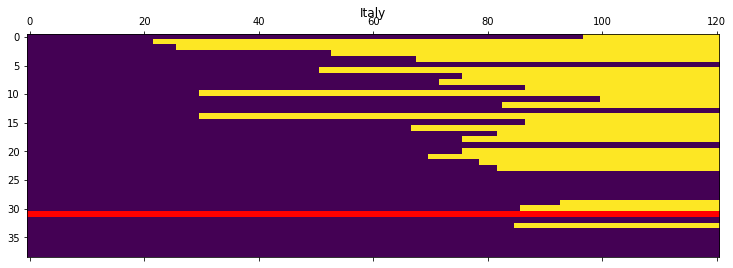

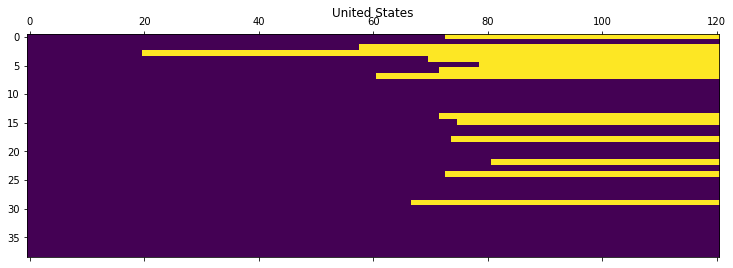

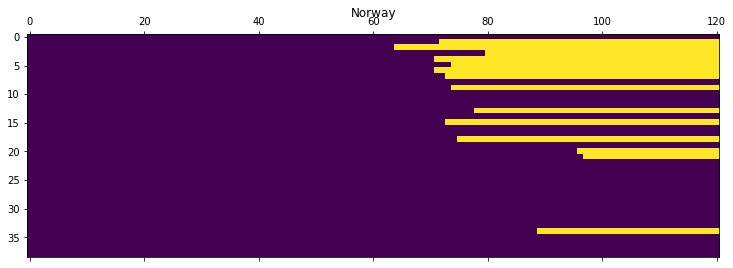

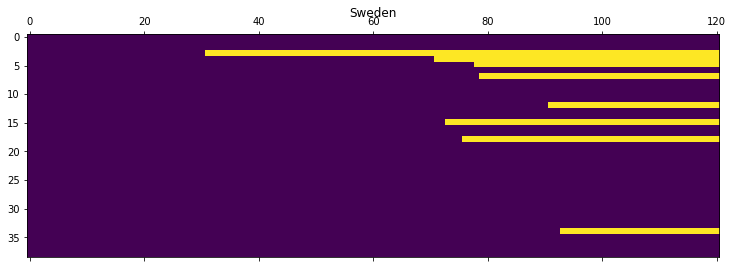

In [4]:
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
plt.matshow(countries_masks['ITA'])
plt.title('Italy')
plt.matshow(countries_masks['USA'])
plt.title('United States')
plt.matshow(countries_masks['NOR'])
plt.title('Norway')
plt.matshow(countries_masks['SWE'])
plt.title('Sweden')

Inevitably, there are significant differences among states. We may quantify this differences.

In [5]:
country_similarity = np.zeros((len(countries),len(countries)))

for i,c in enumerate(countries):
    for j,d in enumerate(countries):
        country_similarity[i,j] = np.sum(countries_masks[c] != countries_masks[d])       

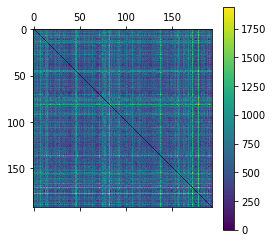

In [6]:
plt.matshow(country_similarity)
plt.colorbar()

This matrix reports the *Hamming distances* between treatments of different countries.

Min distance: 88.0
Max distance: 1941.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Countries with treatments at Hamming distance 88
TTO - STP
Countries with treatments at Hamming distance 98
STP - KNA
Countries with treatments at Hamming distance 101
VNM - BGD
Countries with treatments at Hamming distance 106
VNM - TTO
Countries with treatments at Hamming distance 113
TTO - BGD
Countries with treatments at Hamming distance 126
VNM - JAM
Countries with treatments at Hamming distance 135
TUV - KIR
Countries with treatments at Hamming distance 136
VNM - BDI
Countries with treatments at Hamming distance 141
BDI - BGD
Countries with treatments at Hamming distance 149
TUN - JAM
Countries with treatments at Hamming distance 164
ZWE - LSO
Countries with treatments at Hamming distance 167
ZMB - TZA
Countries with treatments at Hamming distance 170
VNM - STP
Countries with treatments at Ha

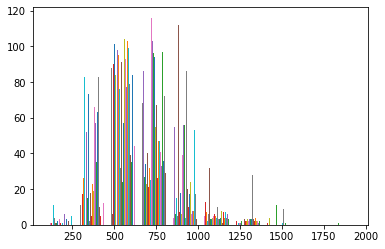

In [10]:
mask = np.ones(country_similarity.shape, dtype=bool)
mask = np.triu(mask,k=0)
masked_country_similarity = np.ma.masked_array(country_similarity,mask)
print('Min distance: {0}'.format(np.min(masked_country_similarity)))
print('Max distance: {0}'.format(np.max(masked_country_similarity)))

plt.hist(masked_country_similarity)
hist = []
for i in range(int(np.max(masked_country_similarity))):
    hist.append(np.sum(masked_country_similarity==i))
print(hist[0:50])

for i in range(80,250):
    locs = np.ma.where(masked_country_similarity==i)
    for l in range(len(locs[0])):
        print('Countries with treatments at Hamming distance {0}'.format(i))
        print('{0} - {1}'.format(countries[locs[0][l]], countries[locs[1][l]]))

A more detailed analysis reveals that distances vary from 88 to 1941, with most of pair of countries having policies with Hamming distances between 250 and 1000 (see histogram). Very few countries have distances lower than 250.

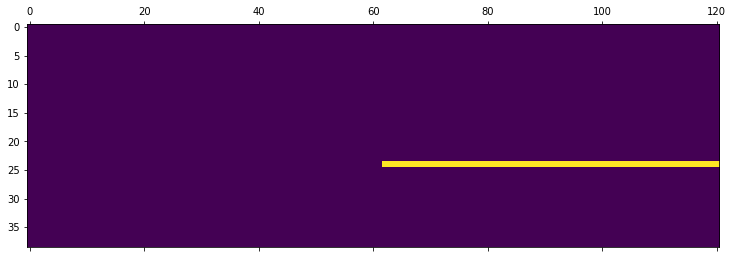

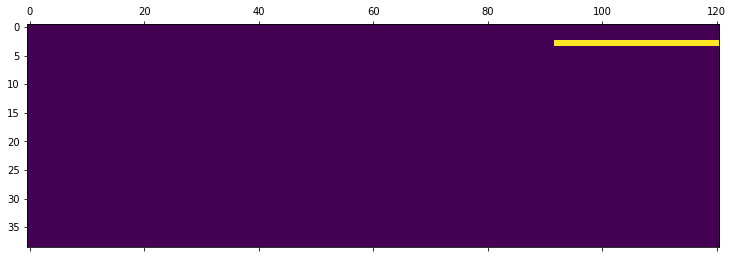

In [9]:
plt.matshow(countries_masks['TTO'])
plt.matshow(countries_masks['STP'])

The smallest difference (88) is recorded between Sao Tome and Principe (STP) and Trinidad and Tobago, which, apparently, enacted only one policy each.

### Aligning the data

The treatments among the countries are now aligned with respect to an absolute time. However, it may make more sense to align them in a relative fashion, with respect to the start of the spread of the disease. This is a non trivial challenge, as we need a criterion to perform this alignment (recording of the first case? recording on the n-th case? percentage of population affected?)

- <font color='red'>How to align data?</font>

### Chosing treatments of reference

Ideally, in a *time-varying analysis* we would have two sets of individuals enacting two policies $\pi_0$ and $\pi_1$, so that we could compute the *average treatment effect* as a difference $E\left[ Y^{\pi_0} \right] - E\left[ Y^{\pi_1} \right]$. The limited amount of samples and vast number of treatments makes it hard to conduct such analysis.

- <font color='red'>Can we group together certain measures and reduce the number of alternatives?</font>
- <font color='red'>Can we evince some natural experiments, by matching similar countries that may be seen as already adjusted for confounder?</font>